# 12.5 Unsupervised Learning
This lab replaced the Lab session in Section 12.5.1 and 12.5.3 (on hierarchical clustering) in the book.

This lab has the following sections:
* 12.5.1: Principal Components Analysis
* 12.5.3: Hierarchical Clustering Methods


Before getting started, we need to get access to the data. To do so, we clone a gitlab repository containing the data. It will make the data available in this Colab in the folder `data`.

In [1]:
!git clone https://git.wur.nl/koots006/msc-course-machine-learning.git data

Cloning into 'data'...
remote: Enumerating objects: 492, done.
remote: Counting objects: 100% (446/446), done.
remote: Compressing objects: 100% (443/443), done.
remote: Total 492 (delta 2), reused 439 (delta 2), pack-reused 46
Receiving objects: 100% (492/492), 35.70 MiB | 14.26 MiB/s, done.
Resolving deltas: 100% (3/3), done.


# Import relevant libraries

In [2]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import scale, StandardScaler
from sklearn import model_selection
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.cross_decomposition import PLSRegression, PLSSVD
from sklearn.metrics import mean_squared_error

# Lab Principal Component Analysis

## 12.5.1 Principal Components Analysis
In this lab, we perform PCA on the `USArrests` data set.
The rows of the data set contain the 50 states of the USA, in alphabetical order.

In [3]:
USArrests = pd.read_csv('data/islr_data/USArrests.csv', index_col=0)

In [5]:
USArrests.head()

,Murder,Assault,UrbanPop,Rape
Alabama,13.2,236,58,21.2
Alaska,10.0,263,48,44.5
Arizona,8.1,294,80,31.0
Arkansas,8.8,190,50,19.5
California,9.0,276,91,40.6


The columns of the data set contain the four variables.

In [6]:
states = USArrests.index
states

Index(['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado',
       'Connecticut', 'Delaware', 'Florida', 'Georgia', 'Hawaii', 'Idaho',
       'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana',
       'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota',
       'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada',
       'New Hampshire', 'New Jersey', 'New Mexico', 'New York',
       'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon',
       'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota',
       'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington',
       'West Virginia', 'Wisconsin', 'Wyoming'],
      dtype='object')

In [7]:
USArrests.columns

Index(['Murder', 'Assault', 'UrbanPop', 'Rape'], dtype='object')

We first briefly examine the data. Using the `.mean()` method we get column-wise average values. We notice that the variables have vastly different means, we see that there are on average three times as many rapes as murders, and more than eight times as many assaults as rapes.

In [8]:
USArrests.mean()

Murder        7.788
Assault     170.760
UrbanPop     65.540
Rape         21.232
dtype: float64

We can also examine the variances of the four variables using the `.var()` function. For more options to examine dataframes, have a look at the `Methods` section in https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html.

In [9]:
USArrests.var()

Murder        18.970465
Assault     6945.165714
UrbanPop     209.518776
Rape          87.729159
dtype: float64

One additional option is to use .describe():

In [10]:
USArrests.describe()

,Murder,Assault,UrbanPop,Rape
count,50.00000,50.000000,50.000000,50.000000
mean,7.78800,170.760000,65.540000,21.232000
std,4.35551,83.337661,14.474763,9.366385
min,0.80000,45.000000,32.000000,7.300000
25%,4.07500,109.000000,54.500000,15.075000
50%,7.25000,159.000000,66.000000,20.100000
75%,11.25000,249.000000,77.750000,26.175000
max,17.40000,337.000000,91.000000,46.000000


Not surprisingly, the variables also have vastly different variances:
 the `UrbanPop` variable measures the percentage of the population in each state living in an urban area, which is not a comparable number to the number of rapes
in each state per 100,000 individuals.
If we failed to scale the variables before performing PCA, then most of the principal components that we observed would be driven by the `Assault` variable, since it has by far the largest mean and variance.
Thus, it is important to standardize the variables to have mean zero and standard deviation one before performing PCA. To achieve mean zero and standard deviation of one, we scale the data using the `StandardScaler()` method from the `sklearn` library.



In [11]:
# Scale the data to have mean 0 and std 1 for each feature
scaler = StandardScaler()
X_scaled = scaler.fit_transform(USArrests)

X_scaled = pd.DataFrame(X_scaled,columns = USArrests.columns)
X_scaled.head()

,Murder,Assault,UrbanPop,Rape
0,1.255179,0.790787,-0.526195,-0.003451
1,0.513019,1.118060,-1.224067,2.509424
2,0.072361,1.493817,1.009122,1.053466
3,0.234708,0.233212,-1.084492,-0.186794
4,0.281093,1.275635,1.776781,2.088814


In [12]:
print("Scaled means: \n", X_scaled.mean())

print("Scaled variances: \n", X_scaled.var())
#note: the variance is not exactly 1 because of a difference in how numpy (used in the scaler) and pandas (used here) calculate variance
#(biased vs unbiased) For our purposes, this does not matter, since the important thing is that each feature now has a comparable range.
#if you want to confirm that according to numpy the variance is 1, use print(X_scaled.std(axis=0)) before making the DataFrame above

Scaled means: 
 Murder     -8.437695e-17
Assault     1.298961e-16
UrbanPop   -4.263256e-16
Rape        8.326673e-16
dtype: float64
Scaled variances: 
 Murder      1.020408
Assault     1.020408
UrbanPop    1.020408
Rape        1.020408
dtype: float64


We now perform principal components analysis using the sklear `PCA()` function, which is one of several functions in `Python` that perform PCA.

In [14]:
pca_fit = PCA(random_state=42).fit(X_scaled)
pca_loadings = pd.DataFrame(pca_fit.components_.T, index=USArrests.columns, columns=['V1', 'V2', 'V3', 'V4'])

The `pca_loadings` dataframe provides the principal component loadings;
each column of this dataframe contains the loading vector corresponding to one of the principal components. If you would matrix-multiply the input data used for PCA with the `pca_loadings` matrix, you get the coordinates of the  data in the rotated coordinate system. These coordinates are the principal component scores.


In [15]:
print(pca_loadings)

                V1        V2        V3        V4
Murder    0.535899  0.418181 -0.341233  0.649228
Assault   0.583184  0.187986 -0.268148 -0.743407
UrbanPop  0.278191 -0.872806 -0.378016  0.133878
Rape      0.543432 -0.167319  0.817778  0.089024


An example of reading the output of the table is as follows: <br/>
 `v1 = 0.53 * Murder + 0.58 * Assault + 0.28 * UrbanPop + 0.54 * Rape`, etc for the other columns.

We see that there are four distinct principal components. This is to
be expected because there are in general $\min(n-1,p)$ informative
principal components in a data set with $n$ observations and $p$
variables.

Using the `PCA()` function, we do not need to explicitly multiply the data by the principal component loading vectors  in order to obtain the principal component score vectors. Instead of just using "fit" as above, we can use "fit_and_transform" to immediately obtain the transformed data. The $50 \times 4$ matrix that we get as output has as its columns the principal component score vectors. That is, the $k$th column is the $k$th principal component score vector.

In [16]:
# Fit the PCA model and transform X to get the principal components
pca = PCA(random_state=42)
pca_df = pd.DataFrame(pca.fit_transform(X_scaled), columns=['PC1', 'PC2', 'PC3', 'PC4'], index=USArrests.index)
pca_df.head()

,PC1,PC2,PC3,PC4
Alabama,0.985566,1.133392,-0.444269,0.156267
Alaska,1.950138,1.073213,2.040003,-0.438583
Arizona,1.763164,-0.745957,0.054781,-0.834653
Arkansas,-0.141420,1.119797,0.114574,-0.182811
California,2.523980,-1.542934,0.598557,-0.341996


In [17]:
pca_df.shape

(50, 4)

We can plot the first two principal components as follows:

In [18]:
def biplot(df_plot, pca_loadings):
  """
  Plots first two principal components.
  Ref: https://github.com/jcrouser/islr-python/blob/master/Lab%2018%20-%20PCA%20in%20Python.ipynb
  """
  fig , ax1 = plt.subplots(figsize=(9,7))

  ax1.set_xlim(-3.5,3.5)
  ax1.set_ylim(-3.5,3.5)

  # Plot Principal Components 1 and 2
  for i in df_plot.index:
      ax1.annotate(i, (df_plot.PC1.loc[i], df_plot.PC2.loc[i]), ha='center')

  # Plot reference lines
  ax1.hlines(0,-3.5,3.5, linestyles='dotted', colors='grey')
  ax1.vlines(0,-3.5,3.5, linestyles='dotted', colors='grey')

  ax1.set_xlabel('PC1')
  ax1.set_ylabel('PC2')
      
  # Plot Principal Component loading vectors, using a second y-axis.
  ax2 = ax1.twinx().twiny() 

  ax2.set_ylim(-1,1)
  ax2.set_xlim(-1,1)
  ax2.set_xlabel('Principal Component loading vectors', color='red')

  # Plot labels for vectors. Variable 'a' is a small offset parameter to separate arrow tip and text.
  a = 1.07  
  for i in pca_loadings[['V1', 'V2']].index:
      ax2.annotate(i, (pca_loadings.V1.loc[i]*a, pca_loadings.V2.loc[i]*a), color='red')

  # Plot vectors
  for i in range(len(pca_loadings.V1)):
   ax2.arrow(0,0,pca_loadings.V1[i], pca_loadings.V2[i], color='r', length_includes_head=True, head_width=0.03)

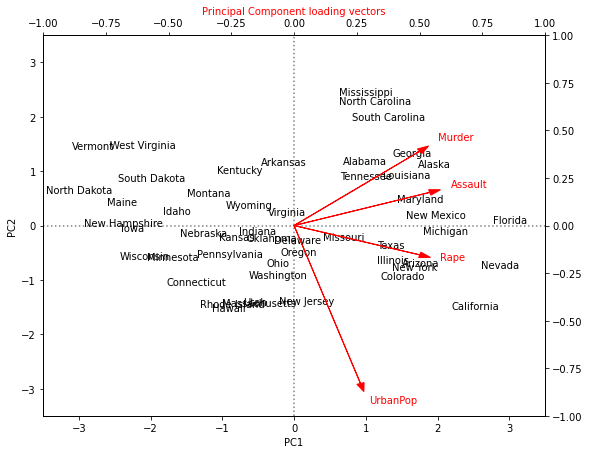

In [19]:
biplot(pca_df, pca_loadings)

Notice that this figure is a mirror image of Figure 12.1. Recall that the principal components are only unique up to a sign change. We can indeed compare the loadings reported in Table 12.1 in the book with the loadings obtained above. This makes clear that for the second PC, there is a sign change. Hence, we can reproduce Figure 12.1 by making a few small changes:

In [20]:
inverse_loadings = pca_loadings
inverse_loadings.V2=-inverse_loadings.V2
inverse_pca_df = pca_df
inverse_pca_df.PC2 = -inverse_pca_df.PC2

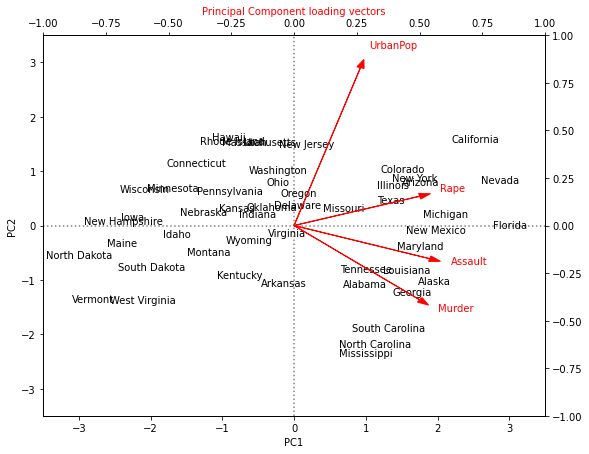

In [21]:
biplot(inverse_pca_df, inverse_loadings)

The `PCA()` function also outputs the explained variance of each principal component. For instance, on the `USArrests` data set, we can access these explained variances from the `pca` object as follows:

In [22]:
pca.explained_variance_

array([2.53085875, 1.00996444, 0.36383998, 0.17696948])

To compute the proportion of variance explained by each principal component, we simply divide the variance explained by each principal component by the total variance explained by all four principal components. This is provided by the `explained_variance_ratio_`.

In [23]:
pca.explained_variance_ratio_

array([0.62006039, 0.24744129, 0.0891408 , 0.04335752])

We see that the first principal component explains $62.0\,\%$ of the variance in the data, the next principal component explains $24.7\,\%$ of the variance, and so forth.
 We can plot the PVE explained by each component, as well as the cumulative PVE, as follows:

In [24]:
def variance_plots(pca, nr_pcs):
  fig , (ax1,ax2) = plt.subplots(1,2, figsize=(9,5))

  # Left plot
  ax1.plot(list(range(1, nr_pcs+1)), pca.explained_variance_ratio_, '-o')
  ax1.set_ylabel('Proportion of Variance Explained')
  ax1.set_ylim(ymin=0.0, ymax=1.05)

  # Right plot
  ax2.plot(list(range(1, nr_pcs+1)), np.cumsum(pca.explained_variance_ratio_), '-ro')
  ax2.set_ylabel('Cumulative Proportion of Variance Explained')
  ax2.set_ylim(ymin=0.0, ymax=1.05)

  for ax in fig.axes:
      ax.set_xlabel('Principal Component')
      ax.set_xlim(0.95, nr_pcs+0.2)    

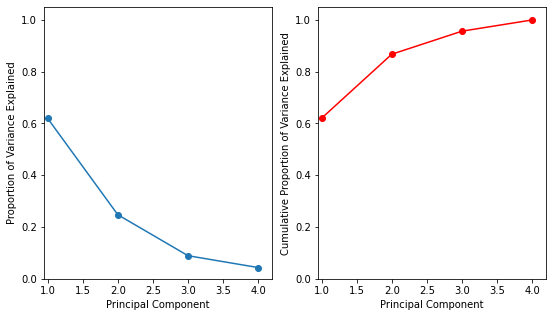

In [25]:
variance_plots(pca,4)

Note that the function `np.cumsum()` computes the cumulative sum of the elements of  a numeric array. For instance:

In [26]:
a = np.asarray([1, 2, 8, -3])
np.cumsum(a)

array([ 1,  3, 11,  8])

## 12.5.3 Clustering
(Note: only Hierarchical Clustering from this lab section.)

In the following example we random data in 2D to which we add a clear group structure. We obtain the hierarchical clustering dendrogram using complete, single, and average linkage clustering, with  Euclidean distance as the default dissimilarity measure.

In [28]:
np.random.seed(19)
X = np.random.normal(size = (50,2))
X[:25,0] += 3 
X[:25,1] -= 4

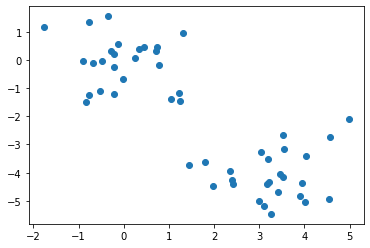

In [29]:
plt.scatter(X[:,0],X[:,1])
plt.show()

In [30]:
import scipy.cluster.hierarchy as shc
from scipy.cluster.hierarchy import fcluster, cut_tree, linkage, dendrogram


The `linkage()` function implements  hierarchical clustering in `Python`. 
We begin by clustering observations using complete linkage.

In [31]:
hc_complete = linkage(X, method='complete')

We could just as easily perform hierarchical clustering with average or single linkage instead:

In [32]:
hc_avg = linkage(X, method='average')
hc_single = linkage(X, method='single')

We can now plot the dendrograms obtained using the `dendrogram()` function. The numbers at the bottom of the plot identify each observation.

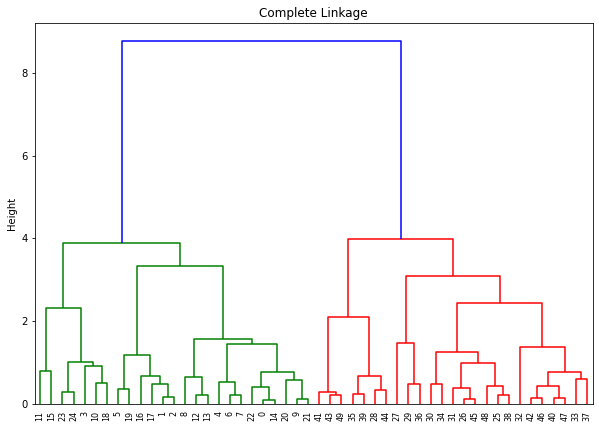

In [33]:
# dendrogram
plt.figure(figsize=(10, 7))  
plt.title("Complete Linkage")
plt.ylabel("Height")
dend = dendrogram(hc_complete)

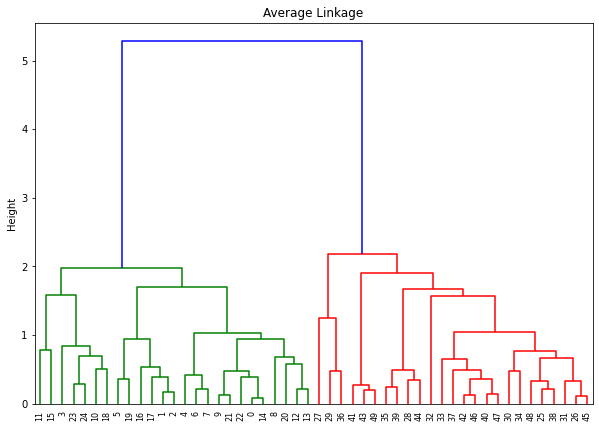

In [34]:
plt.figure(figsize=(10, 7))  
plt.title("Average Linkage")  
plt.ylabel("Height")
dend = dendrogram(hc_avg)

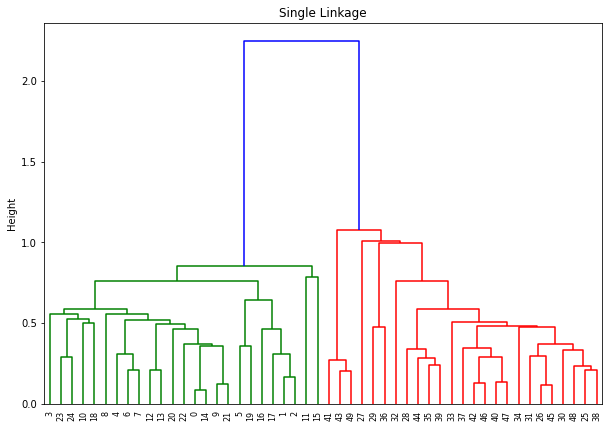

In [35]:
plt.figure(figsize=(10, 7))  
plt.title("Single Linkage")  
plt.ylabel("Height")
dend = dendrogram(hc_single)

To determine the cluster labels for each observation associated with a given cut of the dendrogram, we can use the `cut_tree()` function:

In [36]:
# Note: we add .ravel() so the shape is not (50, 1) [50 elements below each other]
#  but (50, ) instead. If this is not clear, check what you get without .ravel() at the end
cut_tree(hc_complete, 2).ravel()

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1])

In [37]:
cut_tree(hc_avg, 2).ravel()

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1])

In [38]:
cut_tree(hc_single, 2).ravel()

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1])

The second argument to `cut_tree()` is the number of clusters we wish to obtain.
For this data, irrespective of the linkage, hierarchical clustering generally separates the observations into their correct groups. However, this could vary depending on the random seed chosen above. If needed, you can vary the number of clusters, although in this case that does not make much sense:

In [39]:
cut_tree(hc_single, 4).ravel()

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 3,
       1, 1, 1, 1, 1, 3])

To scale the variables before performing hierarchical clustering of the observations, we once again use the `StandardScaler()` function from the `sklearn` library:

In [40]:
# Scaling the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


print('Mean of first feature before scaling - ',X[:,0].mean())
print('Mean of first feature after scaling - ',X_scaled[:,0].mean())

Mean of first feature before scaling -  1.637304066403301
Mean of first feature after scaling -  5.806466418789569e-16


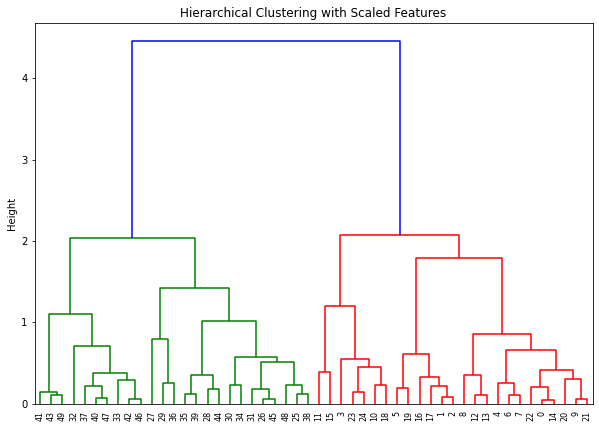

In [41]:
hc_complete_sc = linkage(X_scaled, method='complete')
# dendrogram
plt.figure(figsize=(10, 7))  
plt.title("Hierarchical Clustering with Scaled Features")
plt.ylabel("Height")
dend = dendrogram(hc_complete_sc)

Correlation-based distance can be by passing the `method='correlation'` argument to the `linkage` function. However, this only makes sense for data with at least three features since the absolute correlation between any two observations
with measurements on two features is always 1. Hence, we will cluster a three-dimensional data set. This data set does not contain any true clusters.

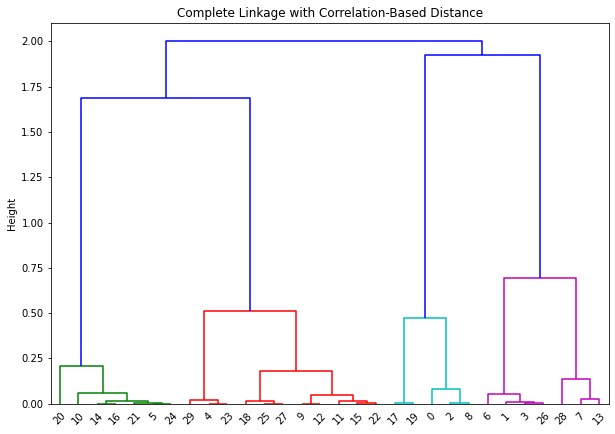

In [42]:
np.random.seed(1)
X = np.random.normal(size=30*3).reshape(30, 3)

hc_complete_corr_based = linkage(X, method='complete', metric='correlation')

# dendrogram
plt.figure(figsize=(10, 7))  
plt.title("Complete Linkage with Correlation-Based Distance")
plt.ylabel("Height")
dend = dendrogram(hc_complete_corr_based)

## 12.5.4 NCI60 Data Example

Unsupervised techniques are often used in the analysis of genomic data. In particular, PCA and hierarchical clustering are popular tools.
 We  illustrate these techniques on the `NCI` cancer cell line microarray data, which consists of $6{,}830$ gene expression measurements on $64$ cancer cell lines.

In [43]:
X = pd.read_csv('data/islr_data/NCI60_X.csv').drop('Unnamed: 0', axis=1)
y = pd.read_csv('data/islr_data/NCI60_y.csv', usecols=[1], skiprows=1, names=['labs'])

Each cell line is labeled with a cancer type, given in `nci.labs`. We do not make use of the cancer types in performing PCA and clustering, as these are unsupervised techniques. But
after performing PCA and clustering, we will
check to see the extent to which these cancer types agree with the results of these unsupervised techniques.

The data has $64$ rows and $6{,}830$ columns.

In [44]:
X.shape

(64, 6830)

In [45]:
X.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,6791,6792,6793,6794,6795,6796,6797,6798,6799,6800,6801,6802,6803,6804,6805,6806,6807,6808,6809,6810,6811,6812,6813,6814,6815,6816,6817,6818,6819,6820,6821,6822,6823,6824,6825,6826,6827,6828,6829,6830
0,0.300000,1.180000,0.550000,1.140000,-0.265000,-7.000000e-02,0.350000,-0.315000,-0.450000,-0.654980,-0.650000,-0.940000,0.310000,0.01501,-0.080000,-2.37,-0.540000,-0.615000,0.000000,-0.519990,-0.370000,-0.290000,-0.174990,0.070000,-0.040000,0.025,-0.740000,-0.479990,-0.450000,-0.930000,0.160000,-0.550000,-0.550010,0.055000,-0.370000,-0.165000,0.210000,0.470000,0.000000,-2.602085e-18,...,0.240000,0.420000,0.100000,0.015000,0.000000,-0.204981,0.185020,0.460000,0.009980,-0.020000,-0.095000,0.210019,0.030000,0.190000,-0.130000,0.124990,0.150000,0.000000,0.375029,0.475000,0.120000,0.590000,0.335000,7.800000e-01,0.410000,-0.630000,1.215000,0.192500,0.000000,-0.820010,-0.990020,0.000000,0.030000,-0.175000,0.629981,-0.030000,0.000000,0.280000,-0.340000,-1.930000
1,0.679961,1.289961,0.169961,0.379961,0.464961,5.799610e-01,0.699961,0.724961,-0.040039,-0.285019,-0.310039,-0.720039,-0.010039,0.00000,-0.570039,0.00,-0.470039,-0.355039,0.004981,-0.480029,-0.140039,-0.090039,0.004971,-0.220039,-0.370039,0.000,-0.320039,0.159971,0.179961,-0.320039,-0.440039,0.349961,0.449951,0.104961,0.489961,0.204961,-0.050039,-0.010039,0.269961,1.996101e-02,...,0.799961,0.269961,0.479961,-0.245039,0.279961,0.014981,-0.075019,0.609961,0.099941,0.629961,0.474961,0.419980,-0.170039,-0.090039,-0.170039,0.494951,-0.120039,0.679961,-0.215010,0.484961,-0.130039,0.029961,0.154961,4.399610e-01,-0.320039,0.009961,0.684961,0.572461,0.629961,-0.400049,-0.270058,-0.300039,-0.250039,-0.535039,0.109941,-0.860039,-1.250049,-0.770039,-0.390039,-2.000039
2,0.940000,-0.040000,-0.170000,-0.040000,-0.605000,0.000000e+00,0.090000,0.645000,0.430000,0.475019,0.410000,0.130000,-0.350000,0.00000,0.000000,0.00,-0.800000,0.000000,-0.004981,0.000000,-0.140000,0.050000,-0.064990,-0.060000,0.290000,0.715,-0.070000,-0.089990,-0.310000,0.580000,-0.480000,0.230000,-0.040010,-0.935000,-0.750000,-0.385000,-0.340000,0.120000,-0.470000,1.700000e-01,...,0.010000,-0.190000,0.420000,0.145000,0.000000,0.065019,-0.644980,-0.070000,0.000000,0.370000,0.565000,0.460020,0.320000,0.100000,0.060000,0.124990,0.270000,0.480000,0.895029,0.225000,0.300000,0.680000,0.715000,5.300000e-01,0.000000,0.120000,0.295000,0.752500,0.380000,0.000000,0.319981,0.120000,-0.740000,-0.595000,-0.270020,-0.150000,0.000000,-0.120000,-0.410000,0.000000
3,0.280000,-0.310000,0.680000,-0.810000,0.625000,-1.387779e-17,0.170000,0.245000,0.020000,0.095019,-0.010000,-0.120000,-0.210000,0.00000,0.610000,-1.02,-0.470000,0.000000,-0.764980,0.000000,-0.310000,-0.620000,-0.284990,-0.540000,-0.520000,-0.135,-0.890000,-0.269990,-0.840000,-0.230000,0.320000,0.000000,0.109990,0.455000,-0.340000,-0.895000,-1.080000,-0.430000,-0.030000,-1.300000e-01,...,-0.400000,-0.470000,0.220000,-0.495000,-0.370000,-0.474981,-0.834981,-0.370000,0.289980,-0.210000,-0.785000,-0.199981,0.060000,0.400000,-0.160000,0.124990,0.380000,0.750000,1.525029,0.695000,0.570000,0.200000,0.185000,-6.938894e-18,0.000000,-0.080000,-0.875000,-0.587500,-0.570000,0.439990,-1.240020,-0.110000,-0.160000,0.095000,-0.350019,-0.300000,-1.150010,1.090000,-0.260000,-1.100000
4,0.485000,-0.465000,0.395000,0.905000,0.200000,-5.000000e-03,0.085000,0.110000,0.235000,1.490019,0.685000,0.605000,0.355000,1.22001,2.425000,0.00,-0.315000,0.310000,-0.519981,-0.074990,-0.865000,-0.455000,-0.499990,-0.245000,-0.235000,-0.330,0.000000,0.015010,-0.105000,-0.225000,-0.105000,-0.275000,-0.575010,-0.450000,-0.465000,-0.390000,-0.995000,-0.355000,0.000000,-4.750000e-01,...,-0.175000,0.015000,1.465000,-0.060000,-0.805000,-0.719981,-2.069981,-0.695000,1.464980,-0.055000,0.120000,0.095020,-0.635000,-0.195000,-0.115000,-0.190010,0.045000,-0.365000,0.150029,-0.030000,0.085000,0.165000,0.190000,1.500

In [46]:
y.shape

(64, 1)

We begin by examining the cancer types for the cell lines.

In [47]:
y['labs'].value_counts()

RENAL          9
NSCLC          9
MELANOMA       8
BREAST         7
COLON          7
OVARIAN        6
LEUKEMIA       6
CNS            5
PROSTATE       2
UNKNOWN        1
K562B-repro    1
K562A-repro    1
MCF7A-repro    1
MCF7D-repro    1
Name: labs, dtype: int64

### PCA on the NCI60 Data

We first perform PCA on the data after scaling the variables (genes) to have standard deviation one, although one could reasonably argue that it is better not to scale the genes.

In [48]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(random_state=42)
pca_df = pd.DataFrame(pca.fit_transform(X_scaled))

We now  plot the first few principal component score vectors, in order to visualize the data. The observations (cell lines) corresponding to a given cancer type will be plotted in the same color, so that we can see to what extent the observations within a cancer type are similar to each other. We first create a simple function that assigns a distinct color to each element of a numeric vector.
The function will be used to assign a  color to each of the $64$ cell lines, based on the cancer type to which it corresponds.

In [49]:
def vec(df,y):
  """
  Function explanation: 
  ....
  """
  import matplotlib.colors as mcolors
  import matplotlib.patches as mpatches
  fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,6))

  color_idx = pd.factorize(y.labs)[0]
  cmap = plt.cm.hsv

  # Left plot
  ax1.scatter(df.iloc[:,0], -df.iloc[:,1], c=color_idx, cmap=cmap, alpha=0.5, s=50)
  ax1.set_ylabel('Principal Component 2')

  # Right plot
  ax2.scatter(df.iloc[:,0], df.iloc[:,2], c=color_idx, cmap=cmap, alpha=0.5, s=50)
  ax2.set_ylabel('Principal Component 3')

  # Custom legend for the classes (y) since we do not create scatter plots per class (which could have their own labels).
  handles = []
  labels = pd.factorize(y.labs.unique())
  norm = mcolors.Normalize(vmin=0.0, vmax=14.0)

  for i, v in zip(labels[0], labels[1]):
      handles.append(mpatches.Patch(color=cmap(norm(i)), label=v, alpha=0.5))

  ax2.legend(handles=handles, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

  # xlabel for both plots
  for ax in fig.axes:
      ax.set_xlabel('Principal Component 1')    

Note that the `vec()` function takes as its argument a dataframe, and returns a plot containing a number of distinct colors equal to the number of unique elements in the dataframe.  We now can plot the principal component score vectors.

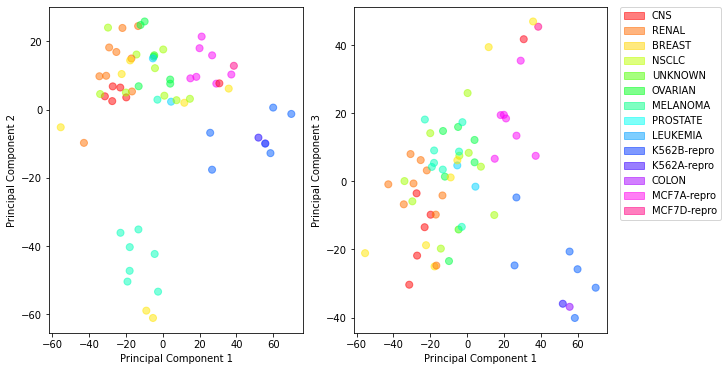

In [50]:
vec(pca_df,y)

The resulting  plots are shown in Figure 12.17 in the book as well. On the whole, cell lines corresponding to a single cancer type do tend to have similar values on the first few
principal component score vectors: they tend to lie near each other in this low-dimensional space. This indicates that cell lines from the same cancer type tend to have pretty similar gene expression levels.
It would not have been possible to visualize the data without using a dimension reduction method such as PCA, since based on the full data set there are
 $6{,}830 \choose 2$ possible scatterplots, none of which would have
been particularly informative.}

We can obtain a summary of the proportion of variance explained (PVE) of the first few principal components using the `pca_summary()` method for a `PCA` object:

In [51]:
def pca_summary(pca):
  
  stds = np.round(np.sqrt(pca.explained_variance_), 4)
  print(len(stds))
  prop_of_var = np.round(pca.explained_variance_ratio_, 4)
  cumul_prop = np.round(pca.explained_variance_ratio_.cumsum(), 4)
  indices = ["PC_{}".format(el) for el in range(1, len(stds)+1)]
  df = pd.DataFrame({"Standard deviation": stds, 
                     "Proportion of variance": prop_of_var, 
                     "Cumulative Proportion": cumul_prop},
                    index=indices)
  print("Importance of components: \n")
  return df

In [52]:
pca_summary(pca)

64
Importance of components: 



,Standard deviation,Proportion of variance,Cumulative Proportion
PC_1,28.0737,0.1136,0.1136
PC_2,21.6512,0.0676,0.1812
PC_3,19.9772,0.0575,0.2387
PC_4,17.1672,0.0425,0.2811
PC_5,16.0981,0.0373,0.3185
...,...,...,...
PC_60,4.7210,0.0032,0.9926
PC_61,4.2087,0.0026,0.9952
PC_62,4.1144,0.0024,0.9976
PC_63,4.0732,0.0024,1.0000


Using the `plot()` function, we can also plot the variance explained by the first few principal components.

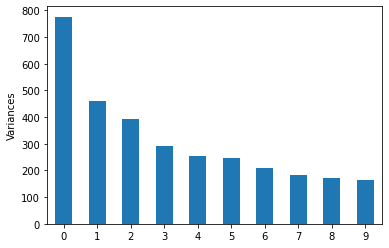

In [53]:
pca_df.iloc[:,:10].var(axis=0, ddof=0).plot(kind='bar', rot=0)
plt.ylabel('Variances');

Note that the height of each bar in the bar plot is given by calculating the variance of each PC.
However, it is more informative to plot the PVE of each principal component (i.e. a scree plot) and the cumulative PVE of each principal component. This can be done with just a little work.

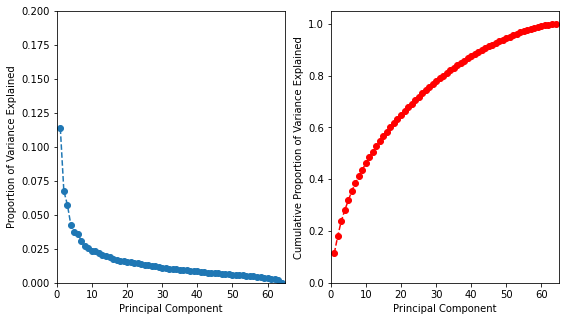

In [54]:
fig , (ax1,ax2) = plt.subplots(1,2, figsize=(9,5))

# Left plot
ax1.plot(list(range(1, 65)), pca.explained_variance_ratio_, '--o')
ax1.set_ylabel('Proportion of Variance Explained')
ax1.set_ylim(ymin=0.0, ymax=0.20)

# Right plot
ax2.plot(list(range(1, 65)), np.cumsum(pca.explained_variance_ratio_), '--ro')
ax2.set_ylabel('Cumulative Proportion of Variance Explained')
ax2.set_ylim(ymin=0.0, ymax=1.05)

for ax in fig.axes:
    ax.set_xlabel('Principal Component')
    ax.set_xlim(0.95, 65)
    ax.set_xticks([0, 10, 20, 30, 40, 50, 60])    

We see (in the right hand side plot) that together, the first seven principal components 
explain around 40% of the variance in the data. This is not a huge
amount of the variance. However, looking at the scree plot, we see that
while each of the first seven principal components explain a substantial
amount of variance, there is a marked decrease in the variance explained
by further principal components. That is, there is an elbow in the plot
after approximately the seventh principal component. This suggests that
there may be little benefit to examining more than seven or so principal
components (though even examining seven principal components may be
difficult).

### Clustering the Observations of the NCI60 Data

We now proceed to hierarchically cluster the cell lines in the `NCI` data, with the goal of finding out whether or not the observations cluster into distinct types of cancer. To begin, we standardize the variables to have mean
 zero and standard deviation one. As mentioned earlier, this step is optional and should be performed only if we want each gene to be on the same *scale*.

We now perform hierarchical clustering of the observations using complete, single, and average linkage. Euclidean distance is used as the dissimilarity measure.

In [55]:
hc_complete = linkage(X_scaled, method='complete')
hc_avg = linkage(X_scaled, method='average')
hc_single = linkage(X_scaled, method='single')

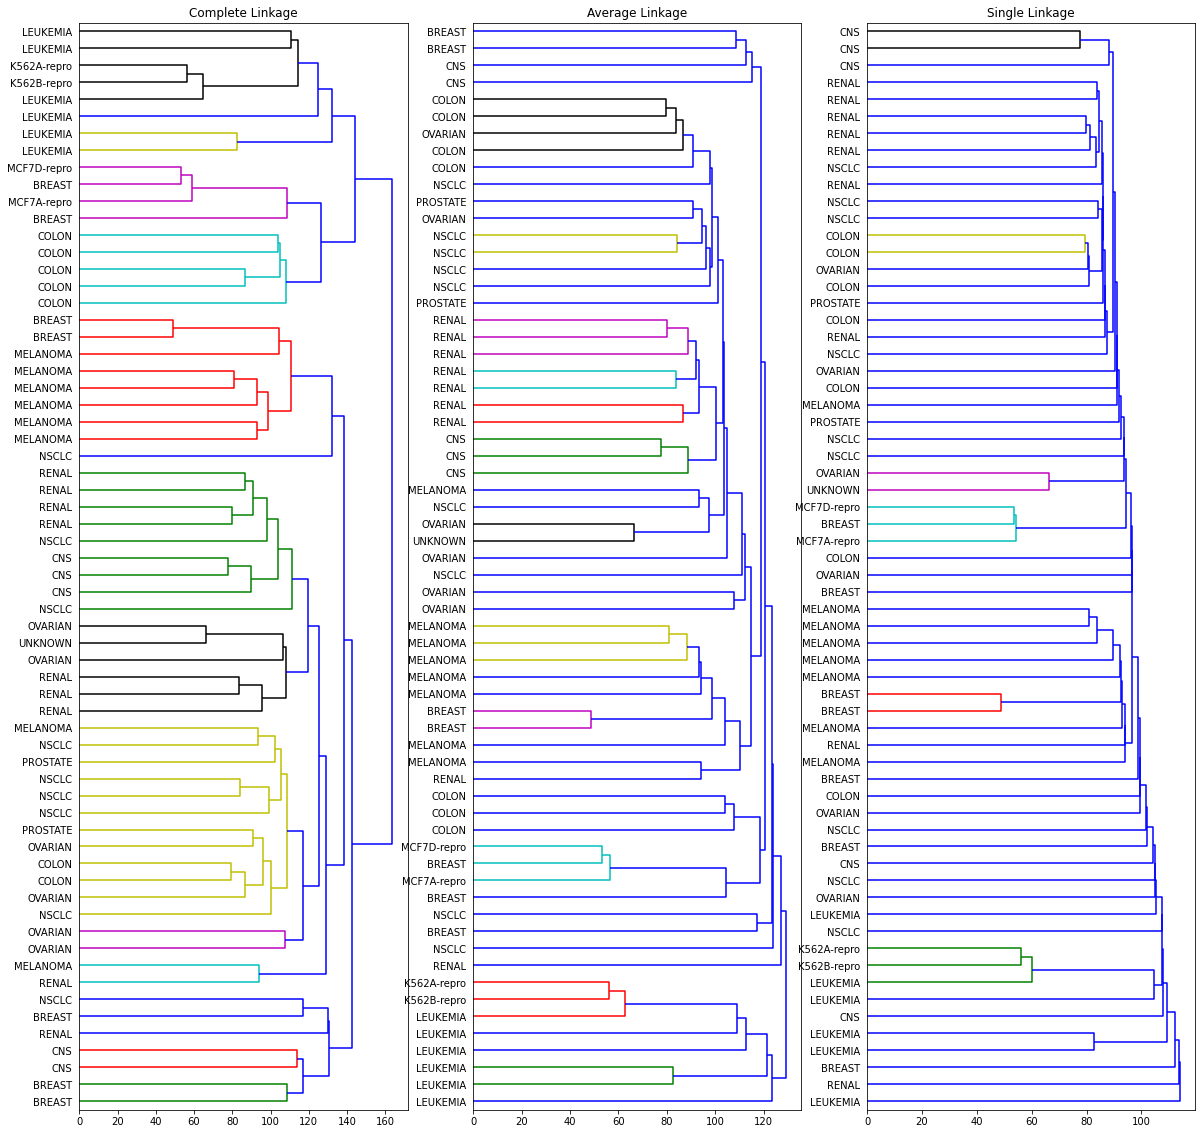

In [56]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(20,20))

for linkage, cluster, ax in zip([hc_complete, hc_avg, hc_single],
                                ['c1','c2','c3'],
                                [ax1,ax2,ax3]):
    cluster = dendrogram(linkage, orientation='right', leaf_font_size=10, ax=ax,labels=y['labs'].tolist())

ax1.set_title('Complete Linkage')
ax2.set_title('Average Linkage')
ax3.set_title('Single Linkage');

The results are shown in Figure 12.19.
We see that the choice of linkage certainly  does affect the results obtained. Typically, single linkage will tend to yield *trailing* clusters: very large clusters onto which
 individual observations attach  one-by-one. On the other hand, complete and average linkage tend to yield more balanced, attractive clusters. For this reason, complete
and average linkage are generally preferred to single linkage.
Clearly cell lines within a single cancer type do tend to cluster together, although the clustering is not perfect. We will use complete linkage hierarchical clustering for the analysis that follows.

We can cut the dendrogram at the height that will yield a particular number of clusters, say four, and then compare with the known cell types:

In [58]:
hc_clusters = cut_tree(hc_complete, 4).ravel()
pd.crosstab(y.labs, hc_clusters).T

labs,BREAST,CNS,COLON,K562A-repro,K562B-repro,LEUKEMIA,MCF7A-repro,MCF7D-repro,MELANOMA,NSCLC,OVARIAN,PROSTATE,RENAL,UNKNOWN
col_0,,,,,,,,,,,,,,
0,2,3,2,0,0,0,0,0,8,8,6,2,8,1
1,3,2,0,0,0,0,0,0,0,1,0,0,1,0
2,0,0,0,1,1,6,0,0,0,0,0,0,0,0
3,2,0,5,0,0,0,1,1,0,0,0,0,0,0


There are some clear patterns. All the leukemia cell lines cluster together, while the breast cancer cell lines are spread out over three different clusters.  We can plot the cut on the dendrogram that produces these four clusters:

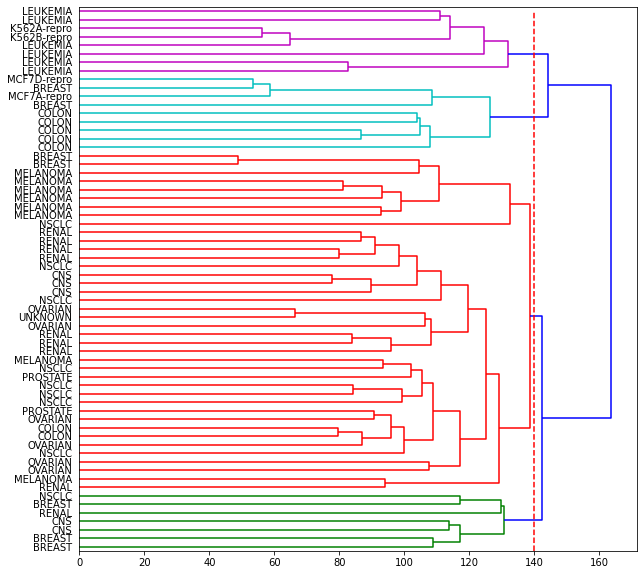

In [57]:
plt.figure(figsize=(10,10))
cut = dendrogram(hc_complete, orientation='right', color_threshold=140, leaf_font_size=10,labels=y['labs'].tolist())
plt.vlines(140,0,plt.gca().yaxis.get_data_interval()[1], colors='r', linestyles='dashed');

The `plt.vlines()` function draws a straight vertical line on top of any existing plot in~`Python`. The argument `x = 140` plots a horizontal line at height $140$ on the
dendrogram; this is the height that results in four distinct clusters. 

# **Credits**:

---

Text is based on R-notebook by the authors, the code for the Chapter 12 sections is based on work that can be found [here](https://github.com/jcrouser/islr-python/blob/master/Lab%2018%20-%20PCA%20in%20Python.ipynb) and [here](https://github.com/hardikkamboj/An-Introduction-to-Statistical-Learning/blob/master/Chapter_10/), with some minor changes. <br/>

